#Multiple-CNN Functional Model using all four e4 sensors and TWristAR data.
Original adaption from base_classifier.ipynb and ind_conv_ankle_hip_wrist.ipynb

This is intended to be the "next step up" classifier for the Fusion of Learned Representations work.   Specifically, it uses the updated TWRistAR loader to provide all combinations of the four channels from the four e4 wristband sensors.   The model has not been updated or tuned on this version.

This is intended to be an interactive Jupyter notebook and not a stand alone .py file as with some of the other load_data code.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* Update and tune the model - before going further need to refactor code - original end-to-end file did train and test.  Separate into training phase so model can be tuned without test info leaking into work.
* Perpherial Temp ptemp is really off.   Need to look at this more, suspect the batch size should be revisited and all signals need to be normalized at a minimum.
* Modularize the model so that the individual learned representation models can be imported.



# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget
from attnSelf import AttnSelf
from attention import Attention

2022-12-16 19:40:11.677487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 19:40:12.280397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64::/home/v_m137/miniconda3/envs/tf-gpu/lib/:/home/v_m137/miniconda3/envs/tf-gpu/lib/
2022-12-16 19:40:12.280584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY

In [2]:
# # Force tensorflow to occupy only one GPU. The first one that is not busy.

# import GPUtil as GPU # from https://github.com/anderskm/gputil
# import sys

# print('OS: ' + sys.platform)
# print(sys.version)

# # Print package name and version number
# print(GPU.__name__ + ' ' + GPU.__version__)

# # Show the utilization of all GPUs in a nice table
# print(GPU.showUtilization())

# # Get the first available GPU, where processing is less than 1%
# firstAvailableGPU = GPU.getFirstAvailable(attempts=5, interval=5, maxLoad=0.01, maxMemory=0.5, verbose=True)
# print('First available GPU id (load < 1%):'),
# print(firstAvailableGPU)

# # Set CUDA_VISIBLE_DEVICES to mask out all other GPUs than the first available device id
# os.environ["CUDA_VISIBLE_DEVICES"] = str(firstAvailableGPU)

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
#enter path to where the datasets can be found in google drive
my_path = './Data'

In [4]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [5]:
# Load numpy arrays from files

x_unlabeled = np.load(my_path+'/PSG/unlabeled_all.npy')
y_unlabeled = np.zeros((x_unlabeled.shape[0],1)) # Create dummy labels
y_unlabeled = np.squeeze(y_unlabeled.astype(np.int64), axis=1) # Convert to integers

x_labeled = np.load(my_path+'/PSG/X50_labeled.npy')
y_labeled = np.load(my_path+'/PSG/y50_labeled.npy')
y_labeled = np.squeeze(y_labeled.astype(np.int64), axis=1) # Convert to integers
sub_labeled = np.load(my_path+'/PSG/sub50_labeled.npy')
sub_labeled = np.squeeze(sub_labeled.astype(np.int64), axis=1) # Convert to integers

x_train = np.load(my_path+'/PSG/x_train.npy')
y_train = np.load(my_path+'/PSG/y_train.npy')
y_train = np.argmax(y_train, axis=1) # Convert one-hot encoded labels to integers

x_valid = np.load(my_path+'/PSG/x_valid.npy')
y_valid = np.load(my_path+'/PSG/y_valid.npy')
y_valid = np.argmax(y_valid, axis=1)

x_test = np.load(my_path+'/PSG/x_test.npy')
y_test = np.load(my_path+'/PSG/y_test.npy')
y_test = np.argmax(y_test, axis=1)

print(get_shapes([x_unlabeled, y_unlabeled, x_labeled, y_labeled, sub_labeled, x_train, y_train, x_valid, y_valid, x_test, y_test]))

x_unlabeled shape is (243933, 500, 12) data type is float32
y_unlabeled shape is (243933,) data type is int64
x_labeled shape is (136175, 500, 12) data type is float32
y_labeled shape is (136175,) data type is int64
sub_labeled shape is (136175,) data type is int64
x_train shape is (41469, 500, 12) data type is float32
y_train shape is (41469,) data type is int64
x_valid shape is (15854, 500, 12) data type is float32
y_valid shape is (15854,) data type is int64
x_test shape is (27959, 500, 12) data type is float32
y_test shape is (27959,) data type is int64



In [6]:
t_names = ['Normal', 'Abnormal']

In [7]:
# Extract channels of interest
x_unlabeled_flow = x_unlabeled[:,:,9]
x_unlabeled_flow = x_unlabeled_flow[:,:,np.newaxis]
x_unlabeled_effort = x_unlabeled[:,:,10:12]

x_labeled_flow = x_labeled[:,:,9]
x_labeled_flow = x_labeled_flow[:,:,np.newaxis]
x_labeled_effort = x_labeled[:,:,10:12]

x_train_flow = x_train[:,:,9]
x_train_flow = x_train_flow[:,:,np.newaxis]
x_train_effort = x_train[:,:,10:12]

x_valid_flow = x_valid[:,:,9]
x_valid_flow = x_valid_flow[:,:,np.newaxis]
x_valid_effort = x_valid[:,:,10:12]

x_test_flow = x_test[:,:,9]
x_test_flow = x_test_flow[:,:,np.newaxis]
x_test_effort = x_test[:,:,10:12]

#Combine test and validation sets
x_test_val_flow = np.concatenate((x_test_flow, x_valid_flow), axis=0)
y_test_val = np.concatenate((y_test, y_valid), axis=0)

x_test_val_effort = np.concatenate((x_test_effort, x_valid_effort), axis=0)
y_test_val = np.concatenate((y_test, y_valid), axis=0)

## Use NNCLR to learn representations

In [8]:
from augmentations import *
from encoder import encoder
from nnclr import NNCLR 

In [9]:
### Hyperparameters
try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

temperature = 0.1        # the temperature for the softmax function in the contrastive loss
queue_size = 10000        # the size of the queue for storing the feature vectors

# input_shape = (96, 4)       # the input shape of each sequence
# width = 64                  # the size of the output embedding vector for each sequence
pretrain_num_epochs = 50   # the number of epochs to pretrain the model
finetune_num_epochs = 20    # The number of epochs to fine-tune the model.
BATCH_SIZE = 16             # the batch size for training
SHUFFLE_BUFFER_SIZE = 1000  # the buffer size for shuffling the dataset
k_size = 16                 # the size of the kernel for the 1D convolutional layer in the encoder
n_classes = 2               # the number of classes in the dataset

### Prepare the data

In [10]:
# Create tf.data.Dataset objects for effort channel
unlabeled_train_dataset_effort = tf.data.Dataset.from_tensor_slices((x_unlabeled_effort, y_unlabeled))
unlabeled_train_dataset_effort = unlabeled_train_dataset_effort.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
unlabeled_train_dataset_effort = unlabeled_train_dataset_effort.prefetch(AUTOTUNE)

labeled_train_dataset_effort = tf.data.Dataset.from_tensor_slices((x_train_effort, y_train))
labeled_train_dataset_effort = labeled_train_dataset_effort.batch(BATCH_SIZE)
labeled_train_dataset_effort = labeled_train_dataset_effort.prefetch(AUTOTUNE)

valid_dataset_effort = tf.data.Dataset.from_tensor_slices((x_valid_effort, y_valid))
valid_dataset_effort = valid_dataset_effort.batch(BATCH_SIZE)
valid_dataset_effort = valid_dataset_effort.prefetch(AUTOTUNE)

test_dataset_effort = tf.data.Dataset.from_tensor_slices((x_test_effort, y_test))
test_dataset_effort = test_dataset_effort.batch(BATCH_SIZE)
test_dataset_effort = test_dataset_effort.prefetch(AUTOTUNE)

test_val_dataset_effort = tf.data.Dataset.from_tensor_slices((x_test_val_effort, y_test_val))
test_val_dataset_effort = test_val_dataset_effort.batch(BATCH_SIZE)
test_val_dataset_effort = test_val_dataset_effort.prefetch(AUTOTUNE)

train_dataset_effort = tf.data.Dataset.zip(
    (unlabeled_train_dataset_effort, labeled_train_dataset_effort)
).prefetch(buffer_size=AUTOTUNE)

2022-12-16 19:40:59.479099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 19:40:59.859420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22319 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:c5:00.0, compute capability: 8.6


### Pretrain the model

First we pretrain a model for the two effort channels.

In [11]:
input_shape_effort = (x_unlabeled_effort.shape[1], x_unlabeled_effort.shape[2])
output_width = 32
k_size = 16

# encoder_effort = keras.Sequential(
#         [
#             layers.Input(shape=input_shape_effort),
#             layers.Conv1D(filters=100, kernel_size=3, activation='relu'),
#             layers.MaxPooling1D(pool_size=2),
#             layers.BatchNormalization(),
#             layers.Dropout(0.2),
            
# 			layers.Conv1D(filters=100, kernel_size=3, activation='relu'),
#             layers.MaxPooling1D(pool_size=2),
# 			layers.BatchNormalization(),
#             layers.Dropout(0.2),
            
#             layers.Conv1D(filters=100, kernel_size=3, activation='relu'),
#             layers.MaxPooling1D(pool_size=2),
#             layers.BatchNormalization(),
#             layers.Dropout(0.2),
            
# 			layers.Flatten(),
#             layers.Dense(100, activation='relu'),
# 			layers.Dense(output_width, activation='relu'),
#         ],
#         name="encoder_effort",
#     )

encoder_effort = encoder(input_shape_effort, output_width, name="encoder_effort")

In [12]:
model_effort = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape_effort, output_width=output_width, n_classes= n_classes, encoder=encoder_effort)
model_effort.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model_effort.build(input_shape=(None, input_shape_effort[0], input_shape_effort[1]))
model_effort.summary()

# pretrain_num_epochs = 10
# pretrain_history = model_effort.fit(
#     train_dataset_effort, epochs=pretrain_num_epochs, validation_data=test_dataset_effort, 
#     verbose=2 # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
#               # Due to a weird bug, the fit function crashes if verbose is set to 1.
# )

Model: "nnclr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Sequ  (None, None, 2)          0         
 ential)                                                         
                                                                 
 classification_augmenter (S  (None, None, 2)          0         
 equential)                                                      
                                                                 
 encoder_effort (Sequential)  (None, 32)               32844     
                                                                 
 projection_head (Sequential  (None, 32)               2112      
 )                                                               
                                                                 
 linear_probe (Sequential)   (None, 2)                 66        
                                                             

In [13]:
EPOCHS = 50
checkpoint_filepath = './tmp/checkpoint_psg_effort'
# Delete old checkpoint files
if os.path.exists(checkpoint_filepath+".index"):
    os.remove(checkpoint_filepath+".index")
    os.remove(checkpoint_filepath+".data-00000-of-00001")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_p_acc',
    mode='max',
    save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_p_acc', patience=20, restore_best_weights=True)

pretrain_history = model_effort.fit(
    train_dataset_effort, epochs=EPOCHS, validation_data=test_val_dataset_effort, 
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
              # Due to a weird bug, the fit function crashes if verbose is set to 1.
    callbacks=[stop_early, model_checkpoint_callback]
)

model_effort.load_weights(checkpoint_filepath)
model_effort.save_weights('./saved_models/psg_effort.h5')

Epoch 1/50


2022-12-16 13:09:26.618024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2022-12-16 13:09:27.579054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-16 13:09:27.588931: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f898401b0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-16 13:09:27.588996: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2022-12-16 13:09:27.594475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-16 13:09:27.701753: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

2592/2592 - 60s - c_loss: 0.4730 - c_acc: 0.8755 - r_acc: 0.7391 - p_loss: 0.4655 - p_acc: 0.7624 - val_p_loss: 1.2182 - val_p_acc: 0.7867 - 60s/epoch - 23ms/step
Epoch 2/50
2592/2592 - 52s - c_loss: 0.5098 - c_acc: 0.9226 - r_acc: 0.7115 - p_loss: 0.4205 - p_acc: 0.7612 - val_p_loss: 1.0771 - val_p_acc: 0.7190 - 52s/epoch - 20ms/step
Epoch 3/50
2592/2592 - 54s - c_loss: 0.5520 - c_acc: 0.9326 - r_acc: 0.7407 - p_loss: 0.4222 - p_acc: 0.7659 - val_p_loss: 0.9794 - val_p_acc: 0.7301 - 54s/epoch - 21ms/step
Epoch 4/50
2592/2592 - 55s - c_loss: 0.4356 - c_acc: 0.9407 - r_acc: 0.7624 - p_loss: 0.4576 - p_acc: 0.7711 - val_p_loss: 1.1648 - val_p_acc: 0.7295 - 55s/epoch - 21ms/step
Epoch 5/50
2592/2592 - 53s - c_loss: 0.4409 - c_acc: 0.9412 - r_acc: 0.7703 - p_loss: 0.4538 - p_acc: 0.7761 - val_p_loss: 1.3043 - val_p_acc: 0.7503 - 53s/epoch - 21ms/step
Epoch 6/50
2592/2592 - 54s - c_loss: 0.4297 - c_acc: 0.9437 - r_acc: 0.7932 - p_loss: 0.4957 - p_acc: 0.7694 - val_p_loss: 0.9657 - val_p_acc

In [14]:
model_effort.load_weights(checkpoint_filepath)
model_effort.save_weights('./saved_models/psg_effort.h5')

In [13]:
model_effort.load_weights('./saved_models/psg_effort.h5')

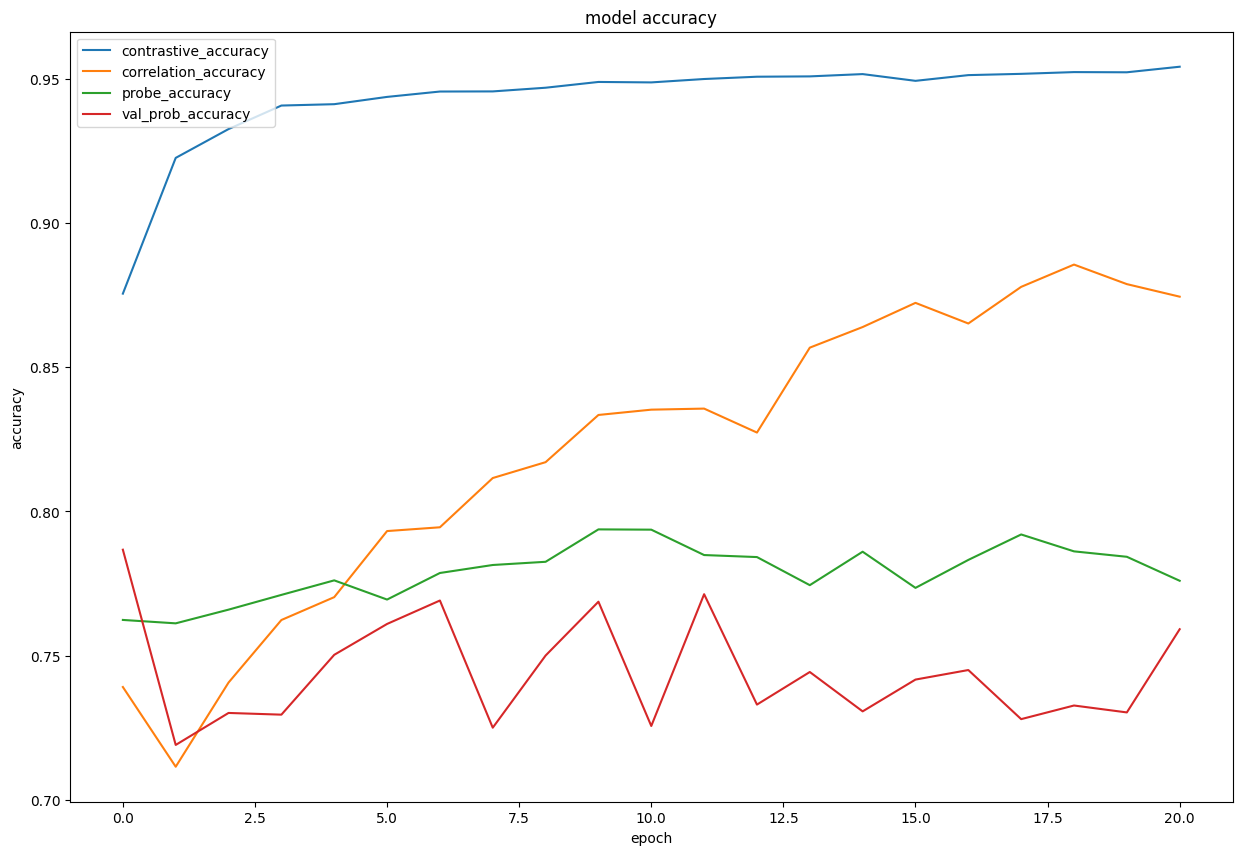

In [16]:
# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.plot(pretrain_history.history['val_p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy', 'val_prob_accuracy'], loc='upper left')
plt.show()

## Plot the learned representations


In [14]:
import matplotlib.pyplot as plt
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

/home/v_m137/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


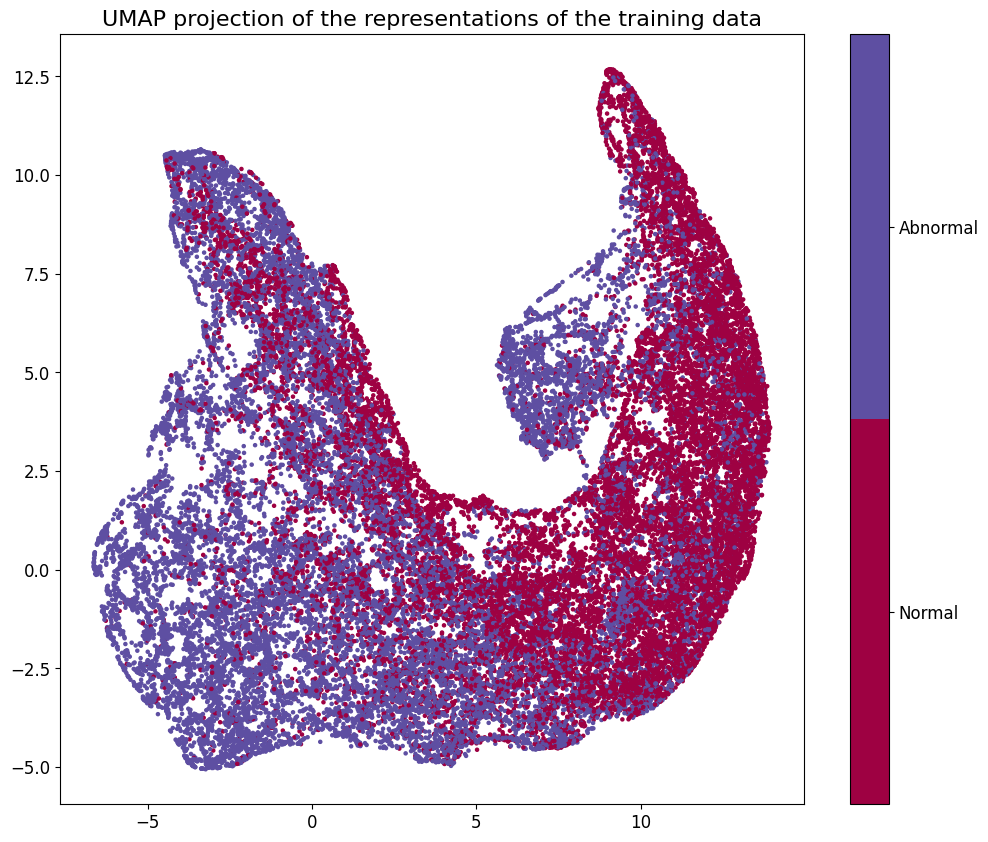

In [15]:
# Plot the representations of the data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2. The color of each point corresponds to its label.

import umap.umap_ as umap
import numpy as np

# Get the representations of the data.
with tf.device('/cpu:0'):
    labeled_feature_vectors = model_effort.encoder(x_train_effort, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(labeled_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the training data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

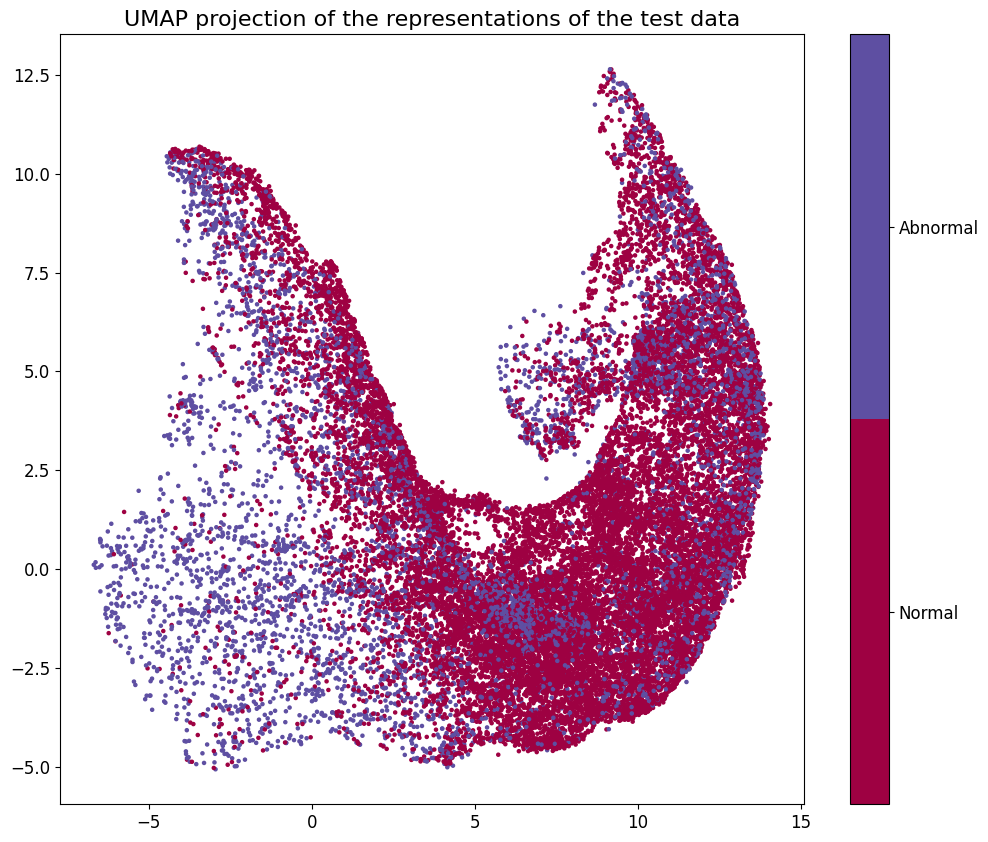

In [16]:
# Get the representations of the data.
with tf.device('/cpu:0'):
    labeled_feature_vectors = model_effort.encoder(x_test_effort, training=False)

# Reduce the dimensionality of the representations to 2.
umap_embeddings = reducer.transform(labeled_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the test data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

In [17]:
# Create tf.data.Dataset objects for BVP channel
unlabeled_train_dataset_flow = tf.data.Dataset.from_tensor_slices((x_unlabeled_flow, y_unlabeled))
unlabeled_train_dataset_flow = unlabeled_train_dataset_flow.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
unlabeled_train_dataset_flow = unlabeled_train_dataset_flow.prefetch(AUTOTUNE)

labeled_train_dataset_flow = tf.data.Dataset.from_tensor_slices((x_train_flow, y_train))
labeled_train_dataset_flow = labeled_train_dataset_flow.batch(BATCH_SIZE)
labeled_train_dataset_flow = labeled_train_dataset_flow.prefetch(AUTOTUNE)

valid_dataset_flow = tf.data.Dataset.from_tensor_slices((x_valid_flow, y_valid))
valid_dataset_flow = valid_dataset_flow.batch(BATCH_SIZE)
valid_dataset_flow = valid_dataset_flow.prefetch(AUTOTUNE)

test_dataset_flow = tf.data.Dataset.from_tensor_slices((x_test_flow, y_test))
test_dataset_flow = test_dataset_flow.batch(BATCH_SIZE)
test_dataset_flow = test_dataset_flow.prefetch(AUTOTUNE)

test_val_dataset_flow = tf.data.Dataset.from_tensor_slices((x_test_val_flow, y_test_val))
test_val_dataset_flow = test_val_dataset_flow.batch(BATCH_SIZE)
test_val_dataset_flow = test_val_dataset_flow.prefetch(AUTOTUNE)

train_dataset_flow = tf.data.Dataset.zip(
    (unlabeled_train_dataset_flow, labeled_train_dataset_flow)
).prefetch(buffer_size=AUTOTUNE)

In [18]:
input_shape_flow = (x_unlabeled_flow.shape[1], x_unlabeled_flow.shape[2])
output_width = 32
k_size = 16

# encoder_flow = keras.Sequential(
#         [
#             layers.Input(shape=input_shape_flow),
#             layers.Conv1D(filters=100, kernel_size=3, activation='relu'),
#             layers.MaxPooling1D(pool_size=2),
#             layers.BatchNormalization(),
#             layers.Dropout(0.2),
            
# 			layers.Conv1D(filters=100, kernel_size=3, activation='relu'),
#             layers.MaxPooling1D(pool_size=2),
# 			layers.BatchNormalization(),
#             layers.Dropout(0.2),
            
#             layers.Conv1D(filters=100, kernel_size=3, activation='relu'),
#             layers.MaxPooling1D(pool_size=2),
#             layers.BatchNormalization(),
#             layers.Dropout(0.2),
            
# 			layers.Flatten(),
#             layers.Dense(100, activation='relu'),
# 			layers.Dense(output_width, activation='relu'),
#         ],
#         name="encoder_flow",
#     )

encoder_flow = encoder(input_shape_flow, output_width, name="encoder_flow")

In [19]:
model_flow = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape_flow, output_width=output_width, n_classes= n_classes, encoder=encoder_flow)
model_flow.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model_flow.build(input_shape=(None, input_shape_flow[0], input_shape_flow[1]))
model_flow.summary()

Model: "nnclr_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Sequ  (None, None, 1)          0         
 ential)                                                         
                                                                 
 classification_augmenter (S  (None, None, 1)          0         
 equential)                                                      
                                                                 
 encoder_flow (Sequential)   (None, 32)                32594     
                                                                 
 projection_head (Sequential  (None, 32)               2112      
 )                                                               
                                                                 
 linear_probe (Sequential)   (None, 2)                 66        
                                                           

In [23]:
EPOCHS = 50
checkpoint_filepath = './tmp/checkpoint_flow'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_p_acc',
    mode='max',
    save_best_only=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_p_acc', patience=20, restore_best_weights=True)

pretrain_history = model_flow.fit(
    train_dataset_flow, epochs=EPOCHS, validation_data=test_val_dataset_flow, 
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
              # Due to a weird bug, the fit function crashes if verbose is set to 1.
    callbacks=[stop_early, model_checkpoint_callback]
)

model_flow.load_weights(checkpoint_filepath)
model_flow.save_weights('./saved_models/psg_flow.h5')

Epoch 1/50
2592/2592 - 59s - c_loss: 1.0505 - c_acc: 0.7436 - r_acc: 0.7527 - p_loss: 0.7757 - p_acc: 0.7502 - val_p_loss: 2.4209 - val_p_acc: 0.7096 - 59s/epoch - 23ms/step
Epoch 2/50
2592/2592 - 57s - c_loss: 0.7975 - c_acc: 0.7984 - r_acc: 0.7963 - p_loss: 0.5446 - p_acc: 0.7810 - val_p_loss: 2.4832 - val_p_acc: 0.6589 - 57s/epoch - 22ms/step
Epoch 3/50
2592/2592 - 55s - c_loss: 0.5906 - c_acc: 0.8225 - r_acc: 0.7850 - p_loss: 0.7911 - p_acc: 0.7794 - val_p_loss: 2.2701 - val_p_acc: 0.7708 - 55s/epoch - 21ms/step
Epoch 4/50
2592/2592 - 56s - c_loss: 0.6626 - c_acc: 0.8375 - r_acc: 0.7904 - p_loss: 0.8380 - p_acc: 0.7962 - val_p_loss: 1.7792 - val_p_acc: 0.7558 - 56s/epoch - 21ms/step
Epoch 5/50
2592/2592 - 58s - c_loss: 0.5810 - c_acc: 0.8422 - r_acc: 0.8020 - p_loss: 0.8689 - p_acc: 0.7853 - val_p_loss: 1.6987 - val_p_acc: 0.7894 - 58s/epoch - 22ms/step
Epoch 6/50
2592/2592 - 58s - c_loss: 0.6143 - c_acc: 0.8495 - r_acc: 0.8195 - p_loss: 0.7802 - p_acc: 0.7990 - val_p_loss: 1.3678 

In [20]:
model_flow.load_weights('./saved_models/psg_flow.h5')

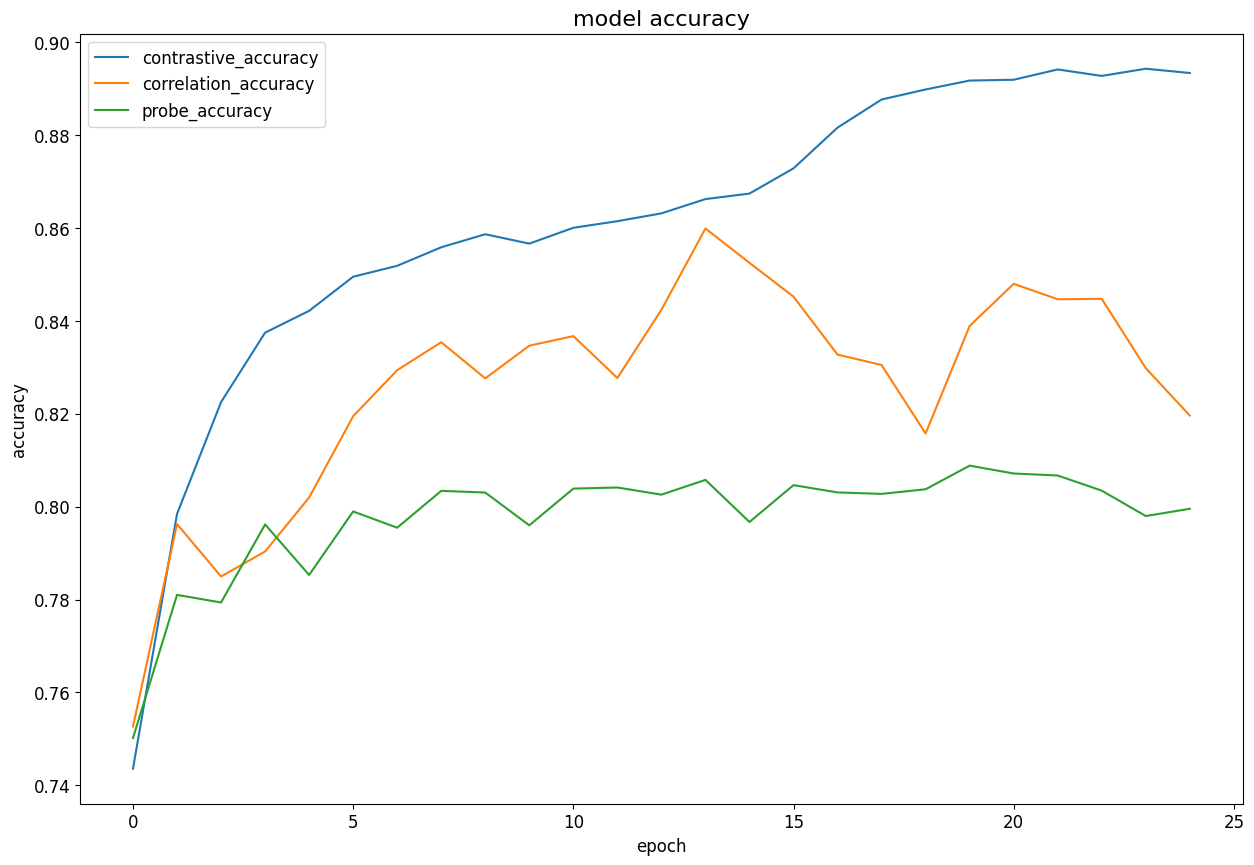

In [24]:
# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy'], loc='upper left')
plt.show()

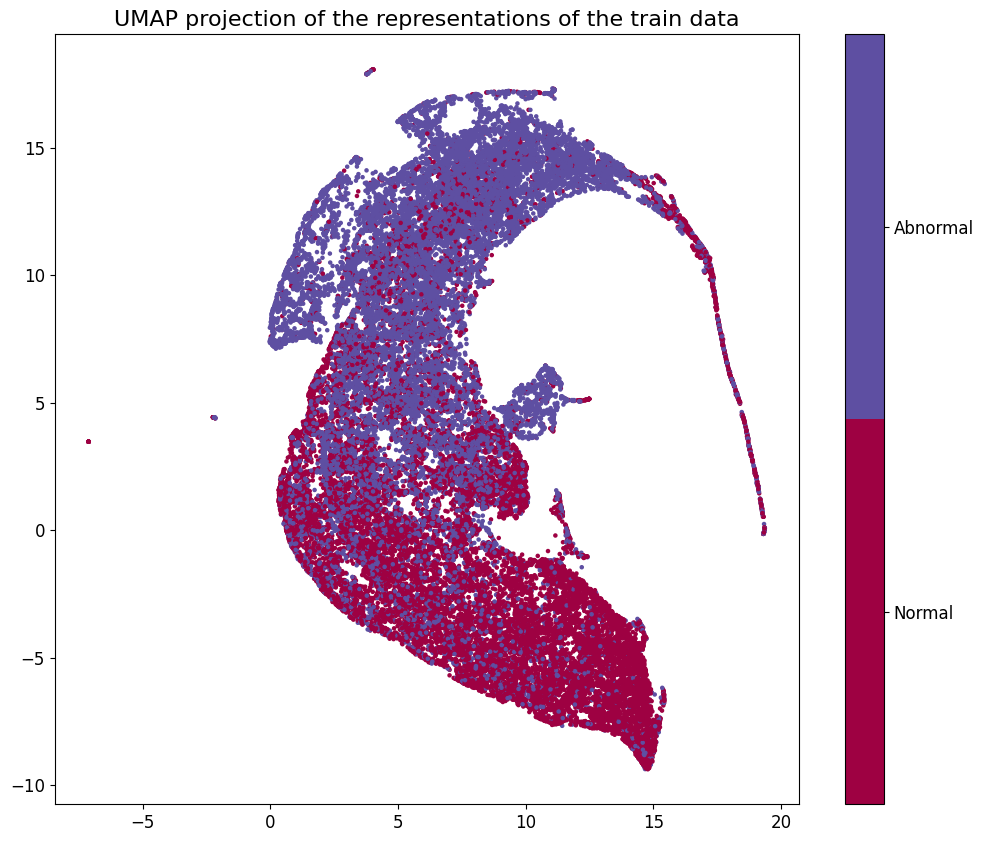

In [21]:
# Plot the representations of the data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2. The color of each point corresponds to its label.

# Get the representations of the data.
with tf.device('/cpu:0'):
    labeled_feature_vectors = model_flow.encoder(x_train_flow, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(labeled_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(n_classes+1)-0.5).set_ticks(np.arange(n_classes))
plt.title('UMAP projection of the representations of the train data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

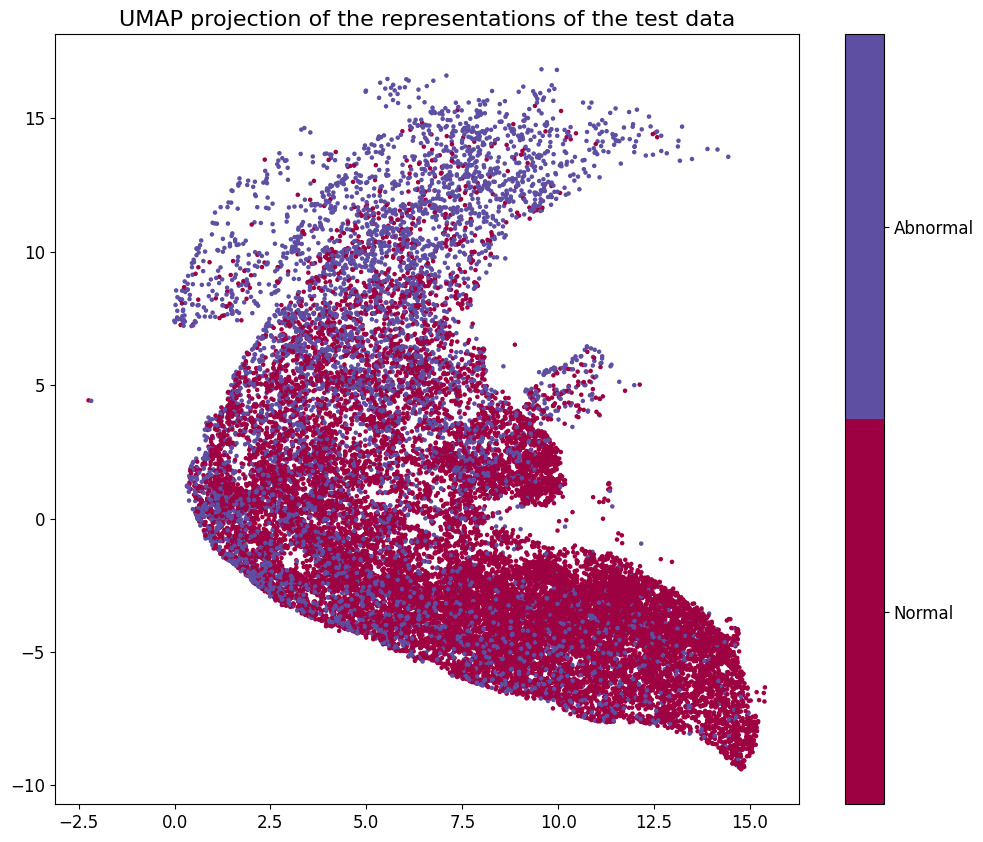

In [22]:
# Get the representations of the  data.
with tf.device('/cpu:0'):
    labeled_feature_vectors = model_flow.encoder(x_test_flow, training=False)

# Reduce the dimensionality of the representations to 2.
umap_embeddings = reducer.transform(labeled_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the representations of the test data')
cbar = plt.colorbar(boundaries=np.arange(n_classes+1)-0.5)
cbar.set_ticks(np.arange(n_classes))
cbar.set_ticklabels(t_names)

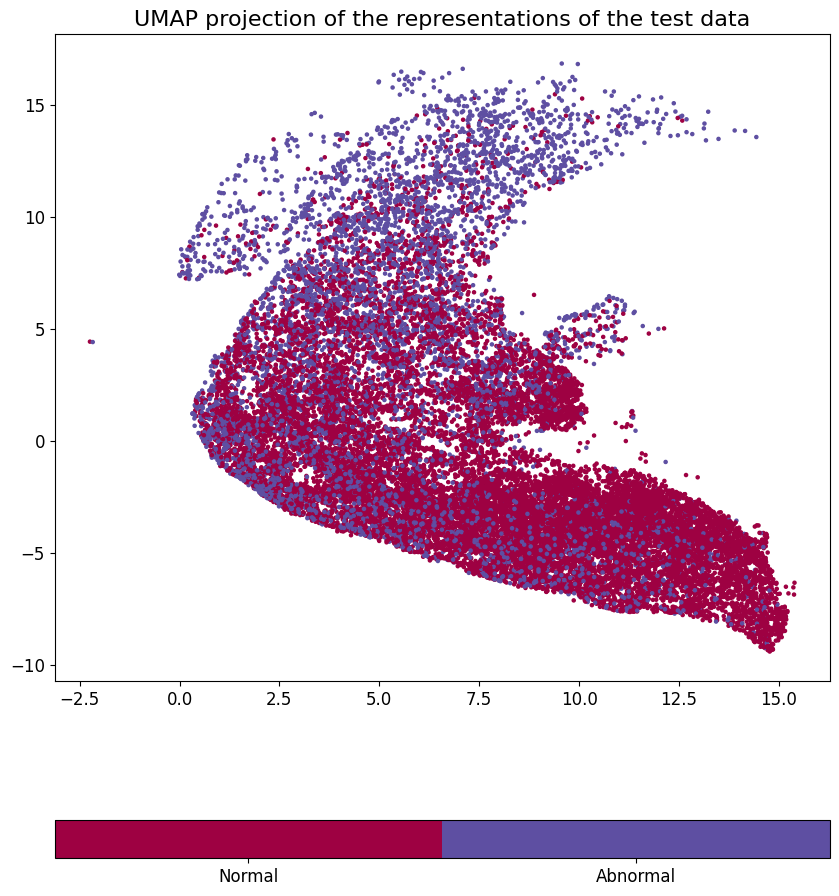

In [23]:
# Same plot with a horizontal colorbar.

t_names = ['Normal', 'Abnormal']
fig, ax = plt.subplots()
fig.set_size_inches(10, 12)
cax = ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
ax.set_title('UMAP projection of the representations of the test data')
cbar = fig.colorbar(cax, boundaries=np.arange(n_classes+1)-0.5, ticks=np.arange(n_classes), orientation='horizontal')
cbar.ax.set_xticklabels(t_names)  # horizontal colorbar

plt.show()

## Fine tune the model

In [28]:
# METRICS = [
#     keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
#     keras.metrics.Precision(name='precision'),
#     keras.metrics.Recall(name='recall'),
#     keras.metrics.AUC(name='auc'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

effort_input = keras.Input(shape = (x_train_effort.shape[1], x_train_effort.shape[2]), name = "effort")
flow_input = keras.Input(shape = (x_train_flow.shape[1], x_train_flow.shape[2]), name = "flow")

effort_augmenter_output = augmenter("effort_classification_augmenter", input_shape=input_shape_effort)(effort_input)
flow_augmenter_output = augmenter("flow_classification_augmenter", input_shape=input_shape_flow)(flow_input)

effort_encoder_output = model_effort.encoder(effort_augmenter_output)
flow_encoder_output = model_flow.encoder(flow_augmenter_output)

# Concatenate the outputs of the two encoders
# concatenated = layers.Concatenate()([effort_encoder_output, flow_encoder_output])
effort_encoder_output = tf.expand_dims(effort_encoder_output, 2) # Add a third dimension to the tensor. Required by the self-attention layer.
flow_encoder_output = tf.expand_dims(flow_encoder_output, 2) # Add a third dimension to the tensor. Required by the self-attention layer.
concatenated = layers.Concatenate(axis=1)([effort_encoder_output, flow_encoder_output])
# concatenated = tf.concat([effort_encoder_output, flow_encoder_output], axis=2)

# # Add a self-attention layer
# concatenated = tf.expand_dims(concatenated, 2) # Add a third dimension to the tensor. Required by the self-attention layer.
# concatenated = AttnSelf(concatenated.shape[1])(concatenated)  # Self-attention layer.
concatenated = Attention(concatenated.shape[1])(concatenated)   # Regular attention layer.
# concatenated = tf.squeeze(concatenated, 2) # Remove the third dimension added by the self-attention layer.

concatenated = layers.Flatten()(concatenated)

# Add a Dense layer with a Relu activation
concatenated = layers.Dense(64, activation="relu")(concatenated)

# Add a softmax classifier on top
output = layers.Dense(n_classes, activation="softmax", name="output")(concatenated)

finetuning_model = keras.Model(
    inputs=[effort_input, flow_input],
    outputs=output,
    name="finetuning_model",
)


finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

print(finetuning_model.summary())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "finetuning_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 effort (InputLayer)            [(None, 500, 2)]     0           []                               
                                                                                                  
 flow (InputLayer)              [(None, 500, 1)]     0           []                               
                                                                                                  
 effort_classification_augmente  (None, None, 2)     0           ['effort[0][0]']                 
 r (Seq

In [29]:
EPOCHS = 300
checkpoint_filepath = './tmp/checkpoint_psg_finetuning'
# Delete old checkpoint files
if os.path.exists(checkpoint_filepath+".index"):
    os.remove(checkpoint_filepath+".index")
    os.remove(checkpoint_filepath+".data-00000-of-00001")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True)

finetuning_history = finetuning_model.fit(
    [x_train_effort, x_train_flow], y_train, epochs=EPOCHS, validation_data=([x_valid_effort, x_valid_flow], y_valid), callbacks=[early_stopping_callback, model_checkpoint_callback]
)

finetuning_model.load_weights(checkpoint_filepath)
finetuning_model.save_weights('./saved_models/psg_finetuning_model.h5')


Epoch 1/300
1296/1296 [==============================] - 31s 19ms/step - loss: 0.3679 - acc: 0.8373 - val_loss: 0.3339 - val_acc: 0.8639
Epoch 2/300
1296/1296 [==============================] - 24s 19ms/step - loss: 0.3433 - acc: 0.8445 - val_loss: 0.3378 - val_acc: 0.8490
Epoch 3/300
1296/1296 [==============================] - 23s 18ms/step - loss: 0.3349 - acc: 0.8513 - val_loss: 0.3615 - val_acc: 0.8592
Epoch 4/300
1296/1296 [==============================] - 22s 17ms/step - loss: 0.3307 - acc: 0.8529 - val_loss: 0.3884 - val_acc: 0.8473
Epoch 5/300
1296/1296 [==============================] - 21s 16ms/step - loss: 0.3273 - acc: 0.8550 - val_loss: 0.3653 - val_acc: 0.8554
Epoch 6/300
1296/1296 [==============================] - 22s 17ms/step - loss: 0.3222 - acc: 0.8598 - val_loss: 0.3388 - val_acc: 0.8637
Epoch 7/300
1296/1296 [==============================] - 21s 16ms/step - loss: 0.3172 - acc: 0.8622 - val_loss: 0.3725 - val_acc: 0.8532
Epoch 8/300
1296/1296 [==================

In [30]:
# finetuning_model.load_weights('./saved_models/psg_finetuning_model.h5')

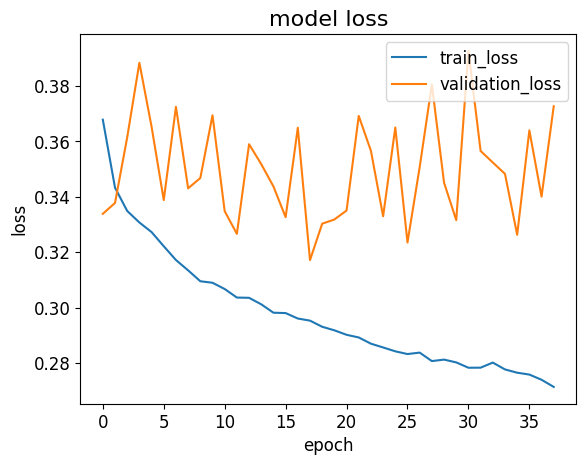

In [31]:
# summarize history for loss

plt.plot(finetuning_history.history['loss'])
plt.plot(finetuning_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper right')
plt.show()

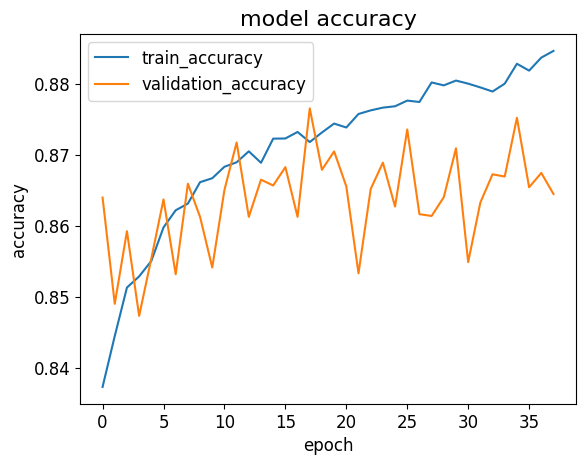

In [32]:
# summarize history for accuracy
plt.plot(finetuning_history.history['acc'])
plt.plot(finetuning_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')
plt.show()

## Evaluate our fine tuned model on the test set

Prediction accuracy: 0.836
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     21788
           1       0.63      0.62      0.62      6171

    accuracy                           0.84     27959
   macro avg       0.76      0.76      0.76     27959
weighted avg       0.83      0.84      0.84     27959

[[19556  2232]
 [ 2361  3810]]


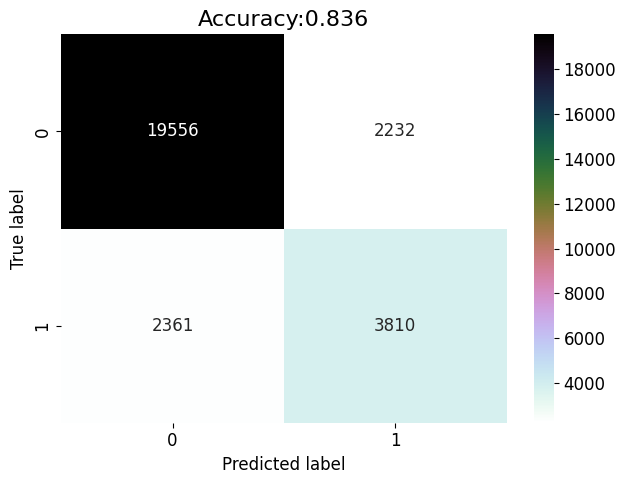

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import numpy as np

#### Show results
predictions = finetuning_model.predict([x_test_effort, x_test_flow], verbose=0, batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
# y_test = np.concatenate([y for x, y in test_dataset], axis=0)
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))

t_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=t_names))
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

## Run Cross Validation experiment on labeled data

In [24]:
def get_fusion_model():
    effort_input = keras.Input(shape = (x_train_effort.shape[1], x_train_effort.shape[2]), name = "effort")
    flow_input = keras.Input(shape = (x_train_flow.shape[1], x_train_flow.shape[2]), name = "flow")

    effort_augmenter_output = augmenter("effort_classification_augmenter", input_shape=input_shape_effort)(effort_input)
    flow_augmenter_output = augmenter("flow_classification_augmenter", input_shape=input_shape_flow)(flow_input)

    model_effort.load_weights('./saved_models/psg_effort.h5')
    model_flow.load_weights('./saved_models/psg_flow.h5')
    effort_encoder_output = model_effort.encoder(effort_augmenter_output)
    flow_encoder_output = model_flow.encoder(flow_augmenter_output)

    # Concatenate the outputs of the two encoders
    # concatenated = layers.Concatenate()([effort_encoder_output, flow_encoder_output])
    effort_encoder_output = tf.expand_dims(effort_encoder_output, 2) # Add a third dimension to the tensor. Required by the self-attention layer.
    flow_encoder_output = tf.expand_dims(flow_encoder_output, 2) # Add a third dimension to the tensor. Required by the self-attention layer.
    concatenated = layers.Concatenate(axis=1)([effort_encoder_output, flow_encoder_output])
    # concatenated = tf.concat([effort_encoder_output, flow_encoder_output], axis=2)

    # # Add a self-attention layer
    # concatenated = tf.expand_dims(concatenated, 2) # Add a third dimension to the tensor. Required by the self-attention layer.
    # concatenated = AttnSelf(concatenated.shape[1])(concatenated)  # Self-attention layer.
    concatenated = Attention(concatenated.shape[1])(concatenated)   # Regular attention layer.
    # concatenated = tf.squeeze(concatenated, 2) # Remove the third dimension added by the self-attention layer.

    concatenated = layers.Flatten()(concatenated)

    # Add a Dense layer with a Relu activation
    concatenated = layers.Dense(64, activation="relu")(concatenated)

    # Add a softmax classifier on top
    output = layers.Dense(n_classes, activation="softmax", name="output")(concatenated)

    finetuning_model = keras.Model(
        inputs=[effort_input, flow_input],
        outputs=output,
        name="finetuning_model",
    )


    finetuning_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
        run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
    )

    return finetuning_model

Fold 0:
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/100


2022-12-16 19:44:58.210798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2022-12-16 19:44:59.179082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-16 19:44:59.185591: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x23a4f250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-16 19:44:59.185650: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2022-12-16 19:44:59.193229: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-16 19:44:59.309290: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

2728/2728 [==============================] - 50s 15ms/step - loss: 0.3340 - acc: 0.8650 - val_loss: 0.4617 - val_acc: 0.7996
Epoch 2/100
2728/2728 [==============================] - 42s 15ms/step - loss: 0.3062 - acc: 0.8762 - val_loss: 0.3972 - val_acc: 0.8289
Epoch 3/100
2728/2728 [==============================] - 41s 15ms/step - loss: 0.2926 - acc: 0.8834 - val_loss: 0.4065 - val_acc: 0.8343
Epoch 4/100
2728/2728 [==============================] - 41s 15ms/step - loss: 0.2855 - acc: 0.8866 - val_loss: 0.2925 - val_acc: 0.8882
Epoch 5/100
2728/2728 [==============================] - 40s 15ms/step - loss: 0.2799 - acc: 0.8888 - val_loss: 0.3796 - val_acc: 0.8488
Epoch 6/100
2728/2728 [==============================] - 40s 15ms/step - loss: 0.2757 - acc: 0.8902 - val_loss: 0.3175 - val_acc: 0.8692
Epoch 7/100
2728/2728 [==============================] - 39s 14ms/step - loss: 0.2728 - acc: 0.8907 - val_loss: 0.3691 - val_acc: 0.8475
Epoch 8/100
2728/2728 [==============================

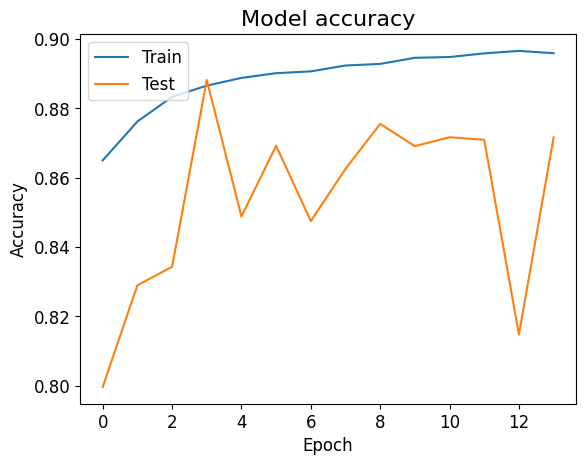

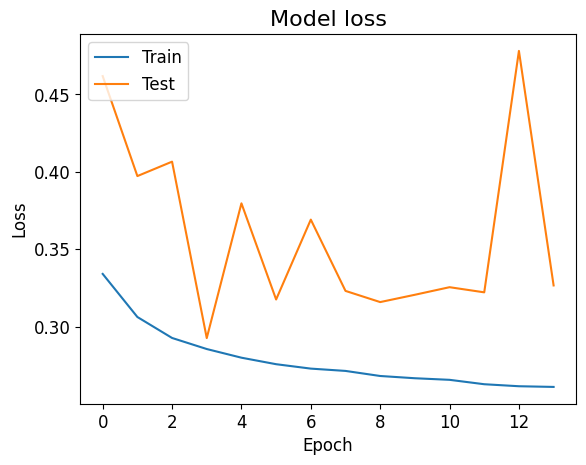

Fold 1:
Epoch 1/100
2730/2730 [==============================] - 46s 15ms/step - loss: 0.3101 - acc: 0.8667 - val_loss: 0.3599 - val_acc: 0.8479
Epoch 2/100
2730/2730 [==============================] - 39s 14ms/step - loss: 0.2845 - acc: 0.8802 - val_loss: 0.3052 - val_acc: 0.8859
Epoch 3/100
2730/2730 [==============================] - 40s 15ms/step - loss: 0.2724 - acc: 0.8874 - val_loss: 0.3664 - val_acc: 0.8579
Epoch 4/100
2730/2730 [==============================] - 39s 14ms/step - loss: 0.2642 - acc: 0.8914 - val_loss: 0.3538 - val_acc: 0.8665
Epoch 5/100
2730/2730 [==============================] - 40s 15ms/step - loss: 0.2585 - acc: 0.8948 - val_loss: 0.3379 - val_acc: 0.8667
Epoch 6/100
2730/2730 [==============================] - 38s 14ms/step - loss: 0.2542 - acc: 0.8960 - val_loss: 0.3538 - val_acc: 0.8630
Epoch 7/100
2730/2730 [==============================] - 40s 15ms/step - loss: 0.2509 - acc: 0.8985 - val_loss: 0.3182 - val_acc: 0.8778
Epoch 8/100
2730/2730 [==========

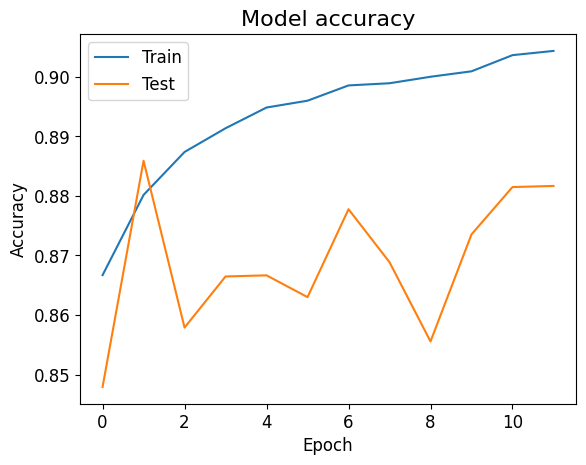

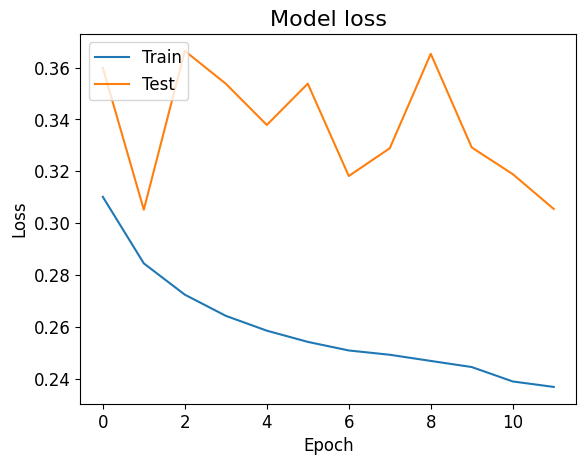

Fold 2:
Epoch 1/100
2797/2797 [==============================] - 47s 15ms/step - loss: 0.3200 - acc: 0.8650 - val_loss: 0.3726 - val_acc: 0.8486
Epoch 2/100
2797/2797 [==============================] - 40s 14ms/step - loss: 0.2920 - acc: 0.8787 - val_loss: 0.4238 - val_acc: 0.8337
Epoch 3/100
2797/2797 [==============================] - 41s 15ms/step - loss: 0.2795 - acc: 0.8843 - val_loss: 0.3757 - val_acc: 0.8475
Epoch 4/100
2797/2797 [==============================] - 42s 15ms/step - loss: 0.2712 - acc: 0.8888 - val_loss: 0.3866 - val_acc: 0.8400
Epoch 5/100
2797/2797 [==============================] - 42s 15ms/step - loss: 0.2681 - acc: 0.8901 - val_loss: 0.4163 - val_acc: 0.8325
Epoch 6/100
2797/2797 [==============================] - 42s 15ms/step - loss: 0.2637 - acc: 0.8928 - val_loss: 0.3949 - val_acc: 0.8460
Epoch 7/100
2797/2797 [==============================] - 41s 15ms/step - loss: 0.2593 - acc: 0.8939 - val_loss: 0.3856 - val_acc: 0.8518
Epoch 8/100
2797/2797 [==========

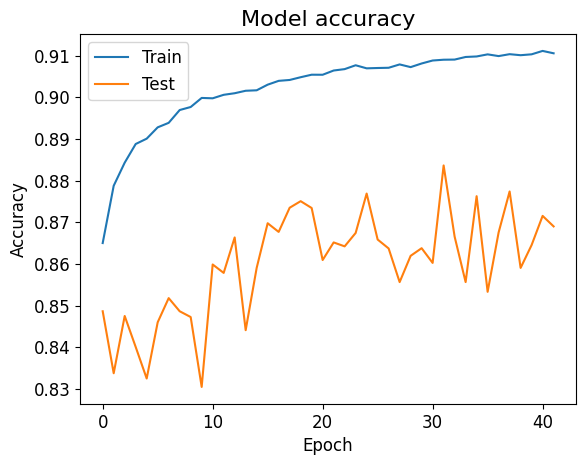

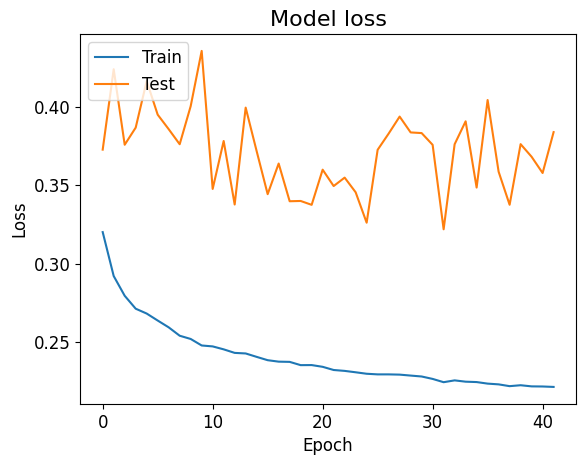

Fold 3:
Epoch 1/100
2676/2676 [==============================] - 44s 14ms/step - loss: 0.3139 - acc: 0.8716 - val_loss: 0.4681 - val_acc: 0.8136
Epoch 2/100
2676/2676 [==============================] - 38s 14ms/step - loss: 0.2957 - acc: 0.8787 - val_loss: 0.5126 - val_acc: 0.7673
Epoch 3/100
2676/2676 [==============================] - 37s 14ms/step - loss: 0.2913 - acc: 0.8803 - val_loss: 0.3739 - val_acc: 0.8407
Epoch 4/100
2676/2676 [==============================] - 43s 16ms/step - loss: 0.2853 - acc: 0.8837 - val_loss: 0.3782 - val_acc: 0.8412
Epoch 5/100
2676/2676 [==============================] - 39s 15ms/step - loss: 0.2806 - acc: 0.8869 - val_loss: 0.3514 - val_acc: 0.8515
Epoch 6/100
2676/2676 [==============================] - 37s 14ms/step - loss: 0.2768 - acc: 0.8893 - val_loss: 0.3681 - val_acc: 0.8440
Epoch 7/100
2676/2676 [==============================] - 39s 15ms/step - loss: 0.2738 - acc: 0.8898 - val_loss: 0.3912 - val_acc: 0.8333
Epoch 8/100
2676/2676 [==========

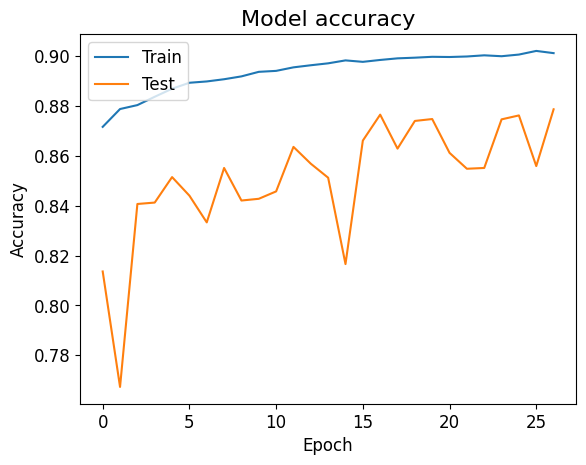

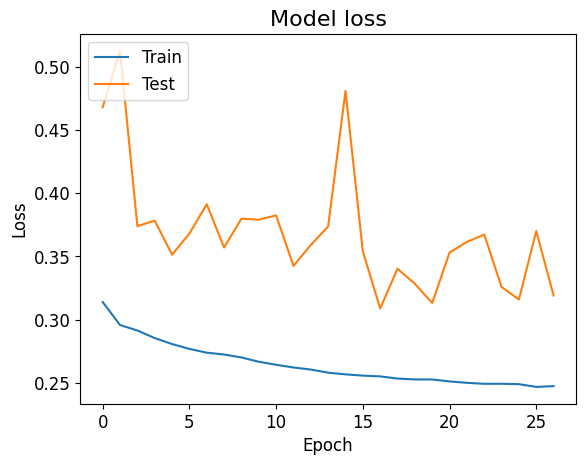

Fold 4:
Epoch 1/100
2663/2663 [==============================] - 47s 15ms/step - loss: 0.2902 - acc: 0.8804 - val_loss: 0.3984 - val_acc: 0.8464
Epoch 2/100
2663/2663 [==============================] - 40s 15ms/step - loss: 0.2654 - acc: 0.8922 - val_loss: 0.3587 - val_acc: 0.8636
Epoch 3/100
2663/2663 [==============================] - 39s 15ms/step - loss: 0.2555 - acc: 0.8967 - val_loss: 0.3852 - val_acc: 0.8621
Epoch 4/100
2663/2663 [==============================] - 39s 15ms/step - loss: 0.2495 - acc: 0.8980 - val_loss: 0.3865 - val_acc: 0.8643
Epoch 5/100
2663/2663 [==============================] - 38s 14ms/step - loss: 0.2452 - acc: 0.9006 - val_loss: 0.3686 - val_acc: 0.8735
Epoch 6/100
2663/2663 [==============================] - 40s 15ms/step - loss: 0.2422 - acc: 0.9020 - val_loss: 0.3524 - val_acc: 0.8756
Epoch 7/100
2663/2663 [==============================] - 43s 16ms/step - loss: 0.2387 - acc: 0.9033 - val_loss: 0.3618 - val_acc: 0.8765
Epoch 8/100
2663/2663 [==========

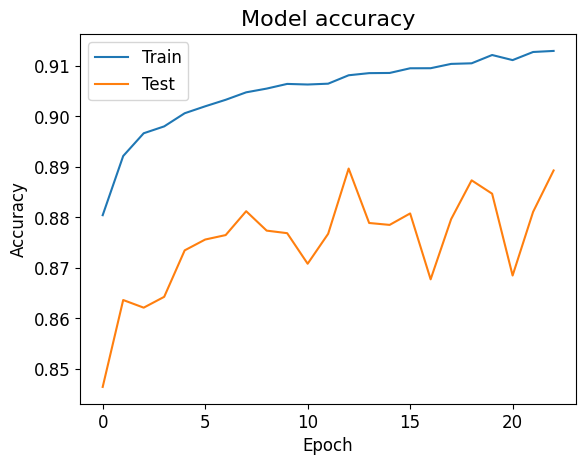

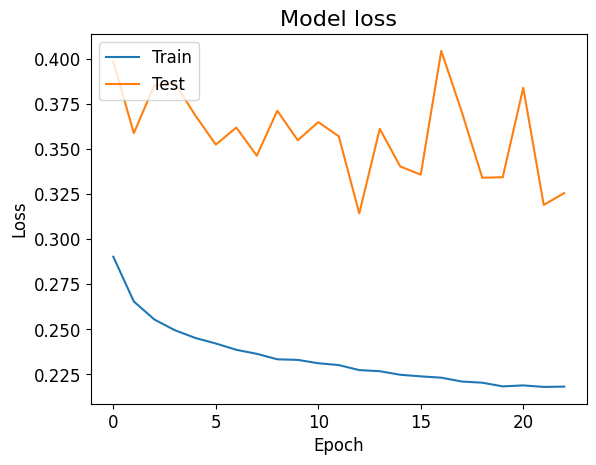

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.32056963443756104 - Accuracy: 86.00780963897705%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.43047478795051575 - Accuracy: 81.67365193367004%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.308988094329834 - Accuracy: 88.04168701171875%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.3710629343986511 - Accuracy: 84.39577221870422%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4220482409000397 - Accuracy: 82.33402967453003%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 84.49059009552002 (+- 2.3455118135756723)
> Loss: 0.37062873840332033
--------------------------

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
import sys

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(x_labeled, y_labeled, groups=sub_labeled)):
    # np.set_printoptions(threshold=sys.maxsize)
    print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"         group={sub_labeled[train_index]}")
    # print(f"  Test:  index={test_index}")
    # print(f"  Groups:   index={sub_labeled[test_index]}")

    x_train_effort, x_train_flow = x_labeled_effort[train_index], x_labeled_flow[train_index]
    x_test_effort, x_test_flow = x_labeled_effort[test_index], x_labeled_flow[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]

    # Do a train/validation group-based split
    gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
    split_out = gss.split(x_train_effort, y_train, groups=sub_labeled[train_index])
    train_index_nested, val_index = next(split_out)

    x_train_effort_nested, x_val_effort = x_train_effort[train_index_nested], x_train_effort[val_index]
    x_train_flow_nested, x_val_flow = x_train_flow[train_index_nested], x_train_flow[val_index]
    y_train_nested, y_val = y_train[train_index_nested], y_train[val_index]

    finetuning_model = get_fusion_model()

    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    EPOCHS = 100
    finetuning_history = finetuning_model.fit(
        [x_train_effort_nested, x_train_flow_nested], y_train_nested, epochs=EPOCHS, validation_data=([x_valid_effort, x_valid_flow], y_valid), callbacks=[stop_early]
    )

    # Generate generalization metrics
    scores = finetuning_model.evaluate([x_test_effort, x_test_flow], y_test, verbose=0)
    print(f"  Test loss: {scores[0]}")
    print(f"  Test accuracy: {scores[1]}")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Generate predictions
    y_pred = finetuning_model.predict([x_test_effort, x_test_flow])
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_per_fold.append(y_pred)
    y_test_per_fold.append(y_test)

    # Plot training & validation accuracy values
    plt.plot(finetuning_history.history['acc'])
    plt.plot(finetuning_history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(finetuning_history.history['loss'])
    plt.plot(finetuning_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Normalized confusion matrix
[[0.87075117 0.12924883]
 [0.23103167 0.76896833]]


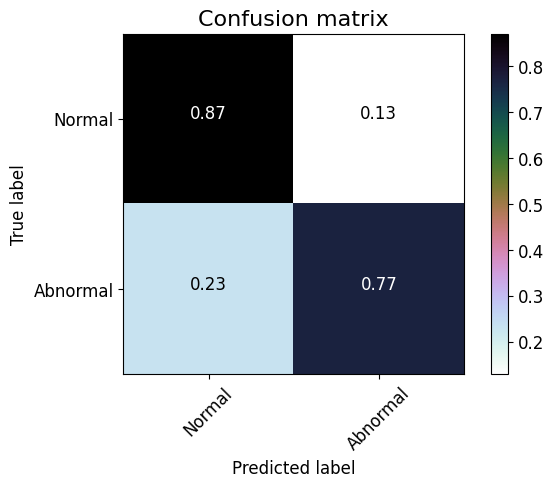

In [27]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

y_pred = np.concatenate(y_pred_per_fold)
y_test = np.concatenate(y_test_per_fold)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes=t_names, normalize=True, title='Confusion matrix', cmap='cubehelix_r')

Confusion matrix, without normalization
[[88713 13168]
 [ 7923 26371]]


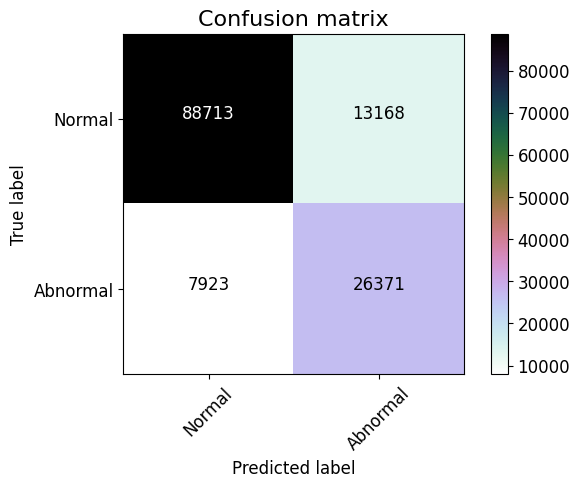

In [29]:
plot_confusion_matrix(cm, classes=t_names, normalize=False, title='Confusion matrix', cmap='cubehelix_r')

In [28]:
print(classification_report(y_test, y_pred, target_names=t_names))

              precision    recall  f1-score   support

      Normal       0.92      0.87      0.89    101881
    Abnormal       0.67      0.77      0.71     34294

    accuracy                           0.85    136175
   macro avg       0.79      0.82      0.80    136175
weighted avg       0.85      0.85      0.85    136175

